Before you turn this assignment in, make sure everything runs as expected. **Restart the kernel and run all cells** (in the menubar, select Kernel$\rightarrow$Restart Kernel and Run All Cells...).

Make sure you fill in any place that says "YOUR ANSWER HERE" or `YOUR CODE HERE` and remove the `raise NotImplementedError()` lines. 

Code blocks starting with a `# tests` comment provide unit tests which have to run without errors in order to get full points. Be aware that there might be further 'secret' tests to check correct implementation! I.e. the provided unit tests are necessary but not sufficient for full points!

You are always welcome to add **additional plots, tests, or debug outputs**.
However, make sure to: **1) not break the automated tests**, and **2) switch off any excessive debug output** when you submit your notebook!

Do not delete or copy existing cells!!

If you process this notebook outside of JupyterHub make sure:
- You may create new cells if necessary, but usually you only need to modify the cells where indicated!
- Do not change the metadata or change cells which are read only!
- If the validation fails after modifying the notebook outside of JupyterHub, fetch a fresh version from the server and only copy/paste the parts that you changed into the fresh notebook!
- If the notebook cannot be autograded because of changes made outside of JupyterHub, you may loose points!

Please add your name and student ID below:

In [1]:
NAME = "Teodor Chakarov"
STUDENT_ID = "12141198"

In [2]:
assert len(NAME) > 0, "Enter your name!"
assert len(STUDENT_ID) > 0, "Enter your student ID!"

# Exercise 1

The submission deadline is **13.11.2022 23:55.**

## Task Description

The goal of this exercise is to model the relationship between weather observations and the prevalence of new weekly influenza infections.

To investigate a potential relationship, we will use two datasets:
 * tri-daily weather reports from 2009 - 2021 of an unnamed city in Europe.
 * weekly reports on new influenza infections in the same city for the same time.

In this exercise, you will 
 * use `pandas` to read, prepare and transform data,
 * use `matplotlib` to visually analyse data,
 * use `scikit-learn` to build prediction models.

The data to be used can be found in: `~/shared/data/`. 

To complete this exercise, you will have to:
* prepare the data, which (at minimum) involves the following:
    - load and prepare the data
    - handling missing values
    - handling outliers
    - temporal alignment of the two datasets
* analyse the data:
    - compare descriptive statistics
    - visually investigate the raw data to gain an understanding of the data identify patterns, outliers etc.,
    - look at the relationship between the variables of interest
* model the relationship:
    - fit a model that predicts new infections from weather observation data
    
    
**Note:** In case you encounter problems with loading and processing the data (tasks 1-5), we will provide you also with a pickled version of a preprocessed and merged datasets that you can use to complete the remaining parts of the exercise (tasks 6-8).

There is a total of 100 points that can be reached which are distributed in two notebooks in the following way:

Notebook A (this notebook), total 55 points:
 - Task 1: 20 points
 - Task 2: 15 points
 - Task 3: 10 points
 - Task 4: 5 points
 - Task 5: 5 points


 Notebook B, total 45 points:
 - Task 6: 15 points
 - Task 7: 20 points
 - Task 8: 10 points

In [3]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import typing

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-vo_cmq2k because the default path (/home/e12141198/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Task 1: Load Data (20 Points)

### 1.1: Weather observations

As a first step, implement the method `load_weather_data()`, which should read all individual (yearly) datasets from the csv files in `data\weather\` into a single `pd.DataFrame` and return it. 

- make sure that you load all the data (2009-2021, 13 years)
- split the tri-daily and daily data (tri-daily data has _7h, _14h, and _19h suffixes for column headers), and convert the tri-daily data from a wide to a long format (use pandas' [wide_to_long](https://pandas.pydata.org/docs/reference/api/pandas.wide_to_long.html) or [melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html#pandas.melt) functions). Introduce a new `hours` column which's values should be taken from the column suffixes.
- make sure all columns are appropriately typed (numeric values -> float, countables, i.e. days -> int, etc.)! Especially the `date` column! See datetime and [`pandas.Timestamp`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html)!
- from the `date` column create `year`, `month`, `week`, `day` columns, where `week` contains the week number of the date. Use Pandas built-in datetime handling features.
- from the wide to long transform, you should have an `hour` column with the 7, 14, or 19 hours values.
- create a `MultiIndex` from the date columns with the following hierarchy: `year` - `month` - `week` - `day` - `hour` (make sure to label them accordingly)

**Hints:**
 
 - LOOK at the data in the original files
 - It is advisable not to append each data set individually, but to read each data frame, store it into a list and  combine them once at the end.
 - Note that for the `precip` data column you will get an unexpected (object) datatype. For this task it is ok to leave it like that, it is due to special values, see next chapters!
 - Your resulting data frame should look as follows:

![Weather data frame example](weather_data_dataframe_sample.png)

In [4]:
# DO NOT MODIFY OR COPY THIS CELL!! 
data_path = os.path.join(os.path.expanduser('~'), "shared", "data")
weather_data_path = os.path.join(data_path, 'weather')
influenza_data_path = os.path.join(data_path, 'influenza')

In [5]:
def load_weather_data(weather_data_path:str) -> typing.Tuple[pd.DataFrame, pd.DataFrame]:
    """ 
    Load all weather data files and combine them into a single Pandas DataFrame.
    Split the tri-daily data from the daily data.
    For the tri-daily data create a new hour column using the indicated hour in the column names.
    Add a week column and a hierarchical index (year, month, week, day, hour).
    For the daily-only data also add a hierarchical index (year, month, week, day).
    
    Parameters
    --------
    weather_data_path: path to directory containing weather data CSV files
    
    Returns
    --------
    weather_data: data frame containing the tri-daily (hours) weather data
    weather_data_daily: data frame containing the daily weather data (e.g. precip, precipType, etc.)
    """

    
    data = pd.DataFrame()
    df_local = []
    for file in glob.glob(weather_data_path + "/*.csv"):
        df_file = pd.read_csv(file, delimiter=";")
        df_local.append(df_file)
    data = pd.concat(df_local, ignore_index=True)

    data.date = pd.to_datetime(data.date, format="%d.%m.%Y")
    data = data.sort_values("date")
    data = data.reset_index(drop=True)
    
    data["year"] = data.date.dt.year
    data["month"] = data.date.dt.month
    data["day"] = data.date.dt.day
    data["week"] = data.date.dt.isocalendar().week

    # Extracting the data for second dataset
    data2 = data[["date",'year', "month", "week", "day","precipType",  "precip"]]
    weather_data_daily = data2.set_index(["year", "month", "week", "day"])


    df_melted = pd.melt(data.drop(["precipType", "precip"], axis=1), id_vars=["date", 'year', "month", "week", "day"])
    attribute = [name[0] for name in df_melted.variable.str.split("_")[:]]
    hours = [name[1] for name in df_melted.variable.str.split("_")[:]]

    df_melted['attributes'] = attribute
    df_melted['hours'] = hours
    df_melted.hours = df_melted.hours.str.replace("h", "").astype(int)
  
    df_melted.drop(["variable"], axis=1, inplace=True)
    df_done = pd.pivot(df_melted, index=["year", "month", "week", "day", "hours", "date"], columns="attributes", values="value")
    df_final = df_done.reset_index().set_index(["year", "month", "week", "day", "hours"])
    df_final["airPressure"] = df_final["airPressure"].astype('float')
    df_final["temp"] = df_final["temp"].astype('float')
    df_final["hum"] = df_final["hum"].astype('int')
    df_final["windBeauf"] = df_final["windBeauf"].astype('int')
    df_final["skyCover"] = df_final["skyCover"].astype('int')
    
    weather_data = df_final

    #raise NotImplementedError()
    return weather_data, weather_data_daily

    

In [6]:
data1, data2 = load_weather_data(weather_data_path)


In [7]:
# DO NOT MODIFY OR COPY THIS CELL!! 
weather_data, daily_weather_data = load_weather_data(weather_data_path)
# print first couple of rows:
print('hourly weather data:')
display(weather_data.head())
print('\ndaily weather data:')
display(daily_weather_data.head())

hourly weather data:


attributes                      date  airPressure  hum  skyCover  temp  \
year month week day hours                                                
2009 1     1    1   7     2009-01-01        999.7   79        10  -4.5   
                    14    2009-01-01        998.8   71         5  -0.1   
                    19    2009-01-01       1000.7   72        10  -1.8   
                2   7     2009-01-02        999.6   67        10  -3.0   
                    14    2009-01-02        998.5   66         9  -1.3   

attributes                 windBeauf windDir  
year month week day hours                     
2009 1     1    1   7              2       W  
                    14             2      NW  
                    19             2      NW  
                2   7              0     NaN  
                    14             2       W


daily weather data:


date precipType  precip
year month week day                              
2009 1     1    1   2009-01-01        NaN       0
                2   2009-01-02       snow  traces
                3   2009-01-03        NaN       0
                4   2009-01-04       snow  traces
           2    5   2009-01-05       snow  traces

In [8]:
# use this cell to inspect the data.

print(f"Data dimensions are: {weather_data.shape[0]} rows and {weather_data.shape[1]} columns")
print(f"\nindex types are: \n-----------------\n{weather_data.index.dtypes}")
print(f"\ncolumn types are: \n-----------------\n{weather_data.dtypes}")

print(f"\nFor daily data: \nData dimensions are: {daily_weather_data.shape[0]} rows and {daily_weather_data.shape[1]} columns")
print(f"\nindex types are: \n-----------------\n{daily_weather_data.index.dtypes}")
print(f"\ncolumn types are: \n-----------------\n{daily_weather_data.dtypes}")


Data dimensions are: 14244 rows and 7 columns

index types are: 
-----------------
year      int64
month     int64
week     UInt32
day       int64
hours     int64
dtype: object

column types are: 
-----------------
attributes
date           datetime64[ns]
airPressure           float64
hum                     int64
skyCover                int64
temp                  float64
windBeauf               int64
windDir                object
dtype: object

For daily data: 
Data dimensions are: 4748 rows and 3 columns

index types are: 
-----------------
year      int64
month     int64
week     UInt32
day       int64
dtype: object

column types are: 
-----------------
date          datetime64[ns]
precipType            object
precip                object
dtype: object


#### Tests
Optional but recommended!
Check if the loading of the data was successful using some assertions.
The points will automatically assigned by the hidden test, try to make sure that you covered all required points from above!

In [9]:
# use this cell to create your own tests. best case: create a test for each requirement above!

# Note: you can add new cells also for the other tasks to add your own tests. 
# But NEVER COPY an existing cell, since this can break the autograding!

In [10]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# TESTS: dimensions should be like this:
assert weather_data.shape[0] == 14244 # 4748
assert weather_data.shape[1] >= 7 # 24

In [11]:
# hidden tests for grading DO NOT MODIFY OR COPY THIS CELL!!

In [12]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

In [13]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

#### Question
Which combination of year+month has the highest number of entries?
- Implement the function below to find the answer!
- Find the respective entry/entries using pandas!!

In [14]:
def get_year_month_highest_entries(data_frame:pd.DataFrame):
    year = 0
    month = 0
    year, month = data_frame.groupby(level=["year", "month"]).count().sum(axis=1).sort_values().idxmax()
    return year, month

In [15]:
# DO NOT MODIFY OR COPY THIS CELL!!
high_num_year, high_num_month = get_year_month_highest_entries(weather_data)
print(f"Month {high_num_month}, of year {high_num_year} has the highest number of entries!")

Month 10, of year 2013 has the highest number of entries!


In [16]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

### 1.2: Influenza infections

Load and prepare the second dataset (`data/influenza/influenza.csv`), which contains the number of new influenza infections on a weekly basis.
- Stack all seasonal data files into one dataframe
- Extract a correct `year` and `week` column from the `Season Week` column, see `data/influenza/descriptions.txt` for details.
- For each entry, extract the year based on the season and month values
- Create a `MultiIndex` from the `year` and `week` columns
- Rename column containing influenza cases to `weekly_infections`
- Make sure that all columns have appropriate types
- Remove rows with missing infection counts
- Your resulting data frame should look as follows:

![Example data frame](influenza_data_dataframe_sample.png)

In [17]:
def load_influenza_data() -> pd.DataFrame:
    """ 
    Load the influenza data from the files into a pndas dataframe
    
    Returns
    --------
    influenza_data: data frame containing the influenza data
    """
    df_local = []
    for file in glob.glob(influenza_data_path + "/*.csv"):
        
        df_file = pd.read_csv(file)
        df_local.append(df_file)

    df = pd.concat(df_local, ignore_index=True)
    year = [name[0] for name in df["Season Week"].str.split("/")[:]]
    weeks = [val.split("_")[1] for val in [name[1] for name in df["Season Week"].str.split("/")[:]]]
                          
    df["year"] = year
    df["week"] = weeks

    df = df[pd.to_numeric(df['New Cases'], errors='coerce').notnull()]
    df.year = df.year.astype(int)
    df.week = df.week.astype(int)
    df["New Cases"] = df["New Cases"].astype(int)
    
    new_years = []
    for index, row in df.iterrows():
        if (row.week < 25):
            new_years.append(row["year"] + 1)
        else:
            new_years.append(row["year"])
                          
    df["new_years"] = new_years
    df_2 = df.drop(["Season Week", "Margin", "year"], axis=1)
    df_2 = df_2.rename(columns={"New Cases":"weekly_infections", "new_years": "year"})
    influenza_data = df_2.set_index(["year", "week"]).dropna(axis=1)
                          
    return influenza_data

In [18]:
# DO NOT MODIFY OR COPY THIS CELL!! 
data_influenza = load_influenza_data()
display(data_influenza)

weekly_infections
year week                   
2019 52                 3500
     51                 5900
     50                 6000
     49                 5900
     48                 5500
...                      ...
     10                 8900
     11                 6200
     12                 5500
     13                 3900
     14                 3300

[310 rows x 1 columns]

In [19]:
# use this cell to inspect the data.

print(f"Data dimensions are: {data_influenza.shape[0]} rows and {data_influenza.shape[1]} columns")
print(f"\nindex types are: \n-----------------\n{data_influenza.index.dtypes}")
print(f"\ncolumn types are: \n-----------------\n{data_influenza.dtypes}")

Data dimensions are: 310 rows and 1 columns

index types are: 
-----------------
year    int64
week    int64
dtype: object

column types are: 
-----------------
weekly_infections    int64
dtype: object


#### Tests
Optional but recommended!
Check if the loading of the data was successful using some assertions.
The points will automatically be assigned by the hidden test, try to make sure that you covered all required points from above!

In [20]:
# use this cell to create your own tests


In [21]:
# tests DO NOT MODIFY OR COPY THIS CELL!! 
# final dimensions should be like this:
assert data_influenza.shape == (310, 1)

In [22]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 

In [23]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 


#### Question
Which combination of year+week shows the highest number of infections? 
- Implement the function below to return the result!
- You should find the respective entry/entries using pandas!
- Return the first answer if there is more than one combination fulfilling these criteria.

In [24]:
def get_year_week_most_infections(data_frame:pd.DataFrame) -> typing.Tuple[int, int]:
    year = 0
    week = 0

    year, week = data_frame.sort_values("weekly_infections", ascending=False).head(1).idxmax()[0]

    return year, week

In [25]:
# DO NOT MODIFY OR COPY THIS CELL!! 
high_num_year, high_num_week = get_year_week_most_infections(data_influenza)
print(f"Week {high_num_week}, of year {high_num_year} has the highest number of infections!")

Week 1, of year 2017 has the highest number of infections!


In [26]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 


## Task 2: Handling Missing Values (15 Points)

If you take a closer look at the data, you will notice that a few of the observations are missing.

There is a wide range of standard strategies to deal with such missing values, including:

- row deletion
- substitution methods (e.g., replace with mean or median)
- hot-/cold-deck methods (impute from a randomly selected similar record)
- regression methods

To decide which strategy is appropriate, it is essential to investigate the mechanism that led to the missing values to find out whether the missing data is missing completely at random, missing at random, or missing not at random. 

 - **MCAR** (Missing Completely At Random) means that there is no relationship between the missingness of the data and any of the values.
 - **MAR** (Missing At Random) means that there is a systematic relationship between the propensity of missing values and the observed data, but not the missing data.
 - **MNAR** (Missing Not At Random) means that there is a systematic relationship between the propensity of a value to be missing and its values. 
 

_______

You talked to the meteorologists who compiled the data to find out more about what mechanisms may have caused the missing values: 

1. They told you that they do not know why some of the temperature (`temp`) and pressure (`airPressure`) readings are missing. They suspect a problem with the IT infrastructure. In any case, the propensity of temperature and pressure values to be missing does not have anything to do with the weather itself.

2. For wind intensity values of 0, the wind direction is not provided (for obvious reasons). 

Check the plausibility of these hypotheses in the data, consider the implications, and devise appropriate strategies to deal with the various missing values.

- Handle missing values for the following columns: `temp`, `airPressure`, `windDir`

To implement your strategy, you can use a range of standard mechanisms provided by Pandas.

#### Visualize some data
Plot temperature (temp) and air pressure (airPressure) as a function of time for the weather data.
Additionally plot the average weekly sky coverage over all years.

In [27]:
# plot the temperature 

# YOUR CODE HERE
#sns.lineplot(x = weather_data.date, y = weather_data.airPressure)


In [28]:
# plot the temperature 

# YOUR CODE HERE
#sns.lineplot(x = weather_data.date, y = weather_data.temp)

In [29]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 14244 entries, (2009, 1, 1, 1, 7) to (2021, 12, 52, 31, 19)
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         14244 non-null  datetime64[ns]
 1   airPressure  14063 non-null  float64       
 2   hum          14244 non-null  int64         
 3   skyCover     14244 non-null  int64         
 4   temp         14013 non-null  float64       
 5   windBeauf    14244 non-null  int64         
 6   windDir      14060 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 853.5+ KB


/tmp/ipykernel_211/3202096178.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped = weather_data.groupby(["year", "month", "week"]).mean().reset_index()


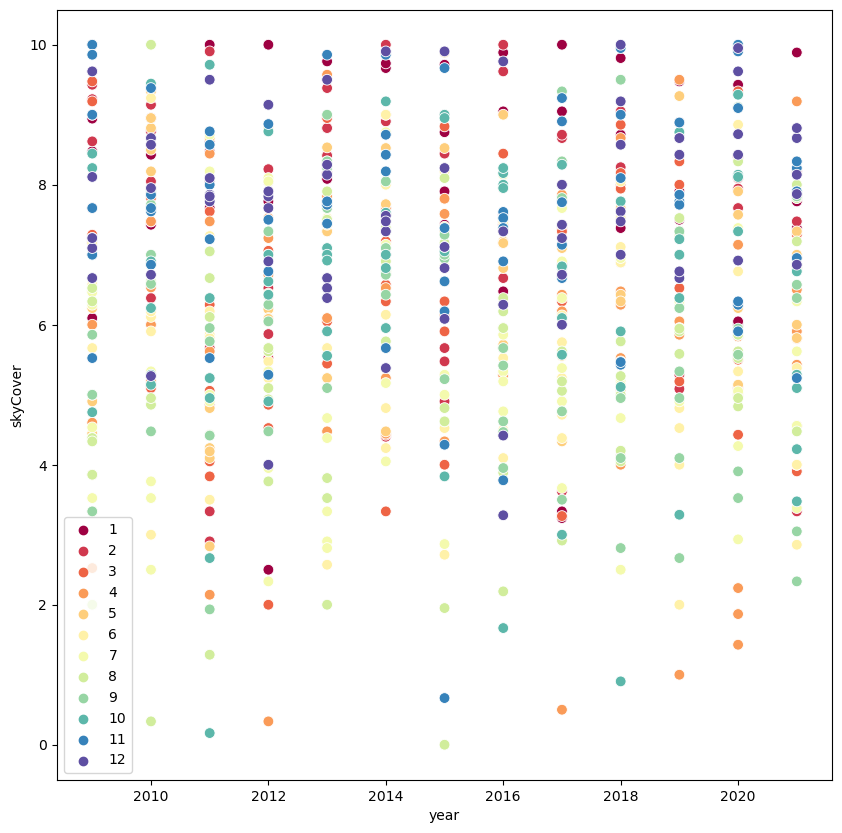

In [30]:
# plot the sky coverage 

# YOUR CODE HERE
df_grouped = weather_data.groupby(["year", "month", "week"]).mean().reset_index()

plt.figure(figsize=(10,10))
sns.scatterplot(x=df_grouped.year, y= df_grouped.skyCover, hue=df_grouped.month, legend="full", palette=sns.color_palette("Spectral", as_cmap=True), s=60)
plt.legend(loc='lower left')
plt.show()

### 2.1: Missing values for temperature and air pressure
Find and visualize missing values for `temp` and `airPressure` columns in the `weather_data` data frame.


#### Data inspection
First, let's visualize the missing data to get a better feel for what is happening.
- Implement the `get_data_around_missing` function below to extract and return a dataframe that only contains rows around missing (`isna`, `isnull`) values for the column indicated by `column`.
- First find missing values in the specified column
- For each missing value, create a dataframe that contain only rows with a date +- `delta_days` from the date of the missing value.
- Put the dataframes into `df_list` and return them.

In [31]:
def get_data_around_missing(df:pd.DataFrame, column:str, 
                            delta_days:int=2) -> typing.List[pd.DataFrame]:
    """ 
    Build a list of dataframes containing missing values indicated by column. 
    Each dataframe contains rows around a missing (isna)
    value in column, within a date of +- delta_days.

    Parameters
    --------
    df: dataframe containing the missing values
    column: the column to look for missing values
    delta_days: the number of days +-around the date of the missing values to keep in the returned data frames
    
    Returns
    --------
    df_list: list of dataframes with some missing data
    """
    # TODO better description
    # check out datetime.timedelta! 
    df_list = []

    for id, row in df.reset_index()[df.reset_index()[column].isna()].iterrows():
        mini_frame = []
        mini_frame.append(df[df.date == row.date])
        for i in range(1, delta_days+1):
          plus_day = df[df.date == row.date + datetime.timedelta(i)]
          minus_day = df[df.date == row.date - datetime.timedelta(i)]
          mini_frame.append(plus_day) 
          mini_frame.append(minus_day)
        df_list.append(pd.concat(mini_frame).sort_values("date"))

    return df_list

    plt.figure(figsize=(8,8))
    plt.plot(df.sort_values("date").date, df[column])
    plt.xticks(rotation = 45)


In [32]:
# DO NOT MODIFY OR COPY THIS CELL!! 
missing_temp_df_list = get_data_around_missing(weather_data, 'temp')
missing_airPressure_df_list = get_data_around_missing(weather_data, 'airPressure')

In [33]:
# tests, DO NOT MODIFY OR COPY THIS CELL!! 
print(len(missing_temp_df_list))
print(len(missing_airPressure_df_list))

assert 150 < len(missing_temp_df_list) < 250, "There should be between 150 and 150 missing values in temp!"
assert 150 < len(missing_airPressure_df_list) < 250, "There should be between 150 and 250 missing values in airPressure!"

assert all([isinstance(cur_el, pd.DataFrame) for cur_el in missing_temp_df_list])
assert all([isinstance(cur_el, pd.DataFrame) for cur_el in missing_airPressure_df_list])

231
181


In [34]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 

In order to be able to see the data, complete the function `plot_value_series` to plot a timeseries of a dataframe identified by `column`:


In [35]:
def plot_value_series(df:pd.DataFrame, column:str) -> None:
    """ 
    Plot the values in column in data frame df
    """
    plt.figure(figsize=(8,8))
    plt.plot(df.reset_index().sort_values(["date"]).date, df[column])
    plt.xticks(rotation = 45)
    plt.show()

Now we use the function to plot a missing value for `temp` and `airPressure`:

In [36]:
missing_temp_df_list[0]

attributes                      date  airPressure  hum  skyCover  temp  \
year month week day hours                                                
2009 1     1    1   7     2009-01-01        999.7   79        10  -4.5   
                    14    2009-01-01        998.8   71         5  -0.1   
                    19    2009-01-01       1000.7   72        10  -1.8   
                2   7     2009-01-02        999.6   67        10  -3.0   
                    14    2009-01-02        998.5   66         9  -1.3   
                    19    2009-01-02        999.8   68        10  -1.7   
                3   7     2009-01-03       1002.7   83         3  -4.8   
                    14    2009-01-03       1000.0   70         5   NaN   
                    19    2009-01-03        998.1   70         1  -3.9   
                4   7     2009-01-04        993.4   75         5  -3.8   
                    14    2009-01-04        991.0   62         9  -0.2   
                    19    2009-01-04        990.1   63         9  -0.5   
           2    5   7     2009-01-05        988.4   64         9  -0.7   
                    14    2009-01-05          NaN   76        10  -0.6   
                    19    2009-01-05        992.3   80        10  -1.3   

attributes                 windBeauf windDir  
year month week day hours                     
2009 1     1    1   7              2       W  
                    14             2      NW  
                    19             2      NW  
                2   7              0     NaN  
                    14             2       W  
                    19             3       W  
                3   7              2       N  
                    14             2       E  
                    19             2       S  
                4   7              4       W  
                    14             4       W  
                    19             3       W  
           2    5   7              4       W  
                    14             3       W  
                    19             2       W

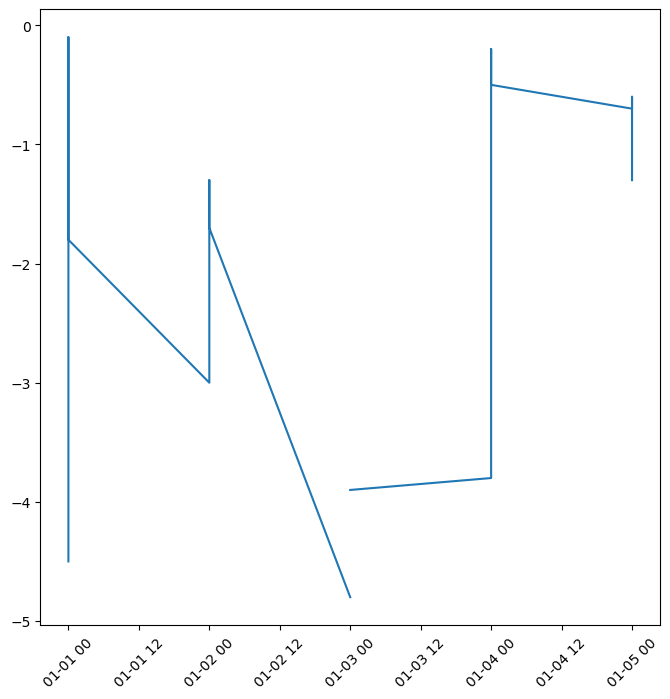

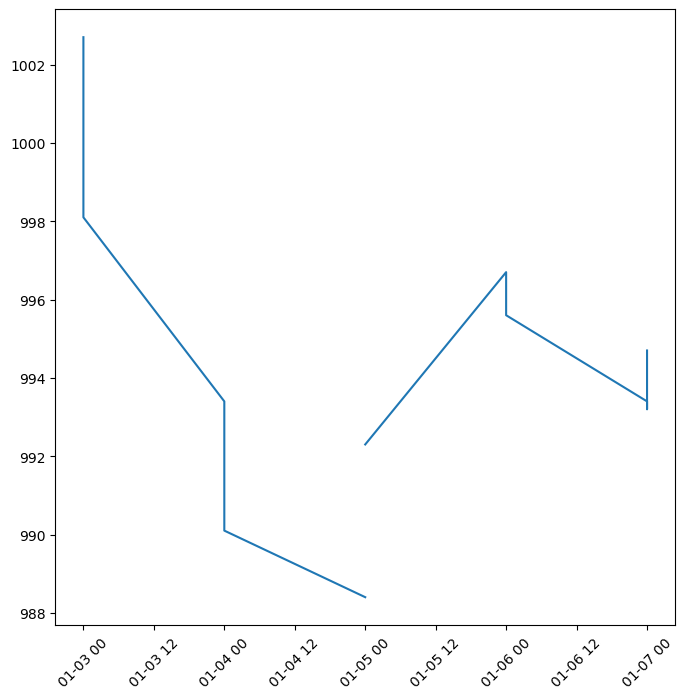

In [37]:
# tests,  DO NOT MODIFY OR COPY THIS CELL!! 
plot_value_series(missing_temp_df_list[0], 'temp')
plot_value_series(missing_airPressure_df_list[0], 'airPressure')

In [38]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 

#### Handle missing temperature values
Use the plots above and the information that was given to us by the meterologist to decide on a suitable strategy to fix the missing values.

- Implement the function below to get rid of the missing values for temperature (`temp`).
- Choose an appropriate strategy to fill in the misssing values.

In [39]:
def handle_missing_temp_values(df:pd.DataFrame) -> pd.DataFrame:
    """ 
    Handle missing temperature values appropriately!

    Parameters
    --------
    df: dataframe containing the missing values
    
    Returns
    --------
    df_ret: dataframe with fixed values
    """
    df_ret = df.copy()

    df_ret = df_ret.fillna(method="ffill")

    return df_ret

Plot the fixed stretch of temp values from above, and compare to the unmodified version:

In [40]:
missing_temp_idx = 0

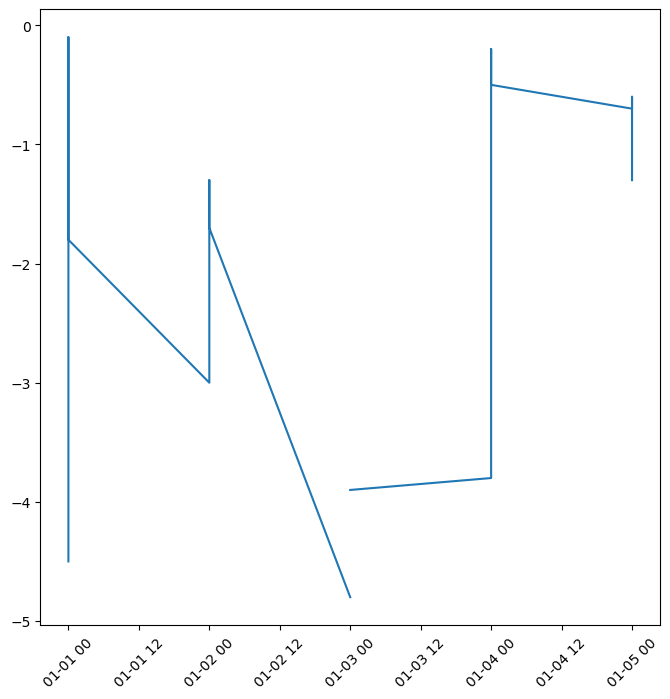

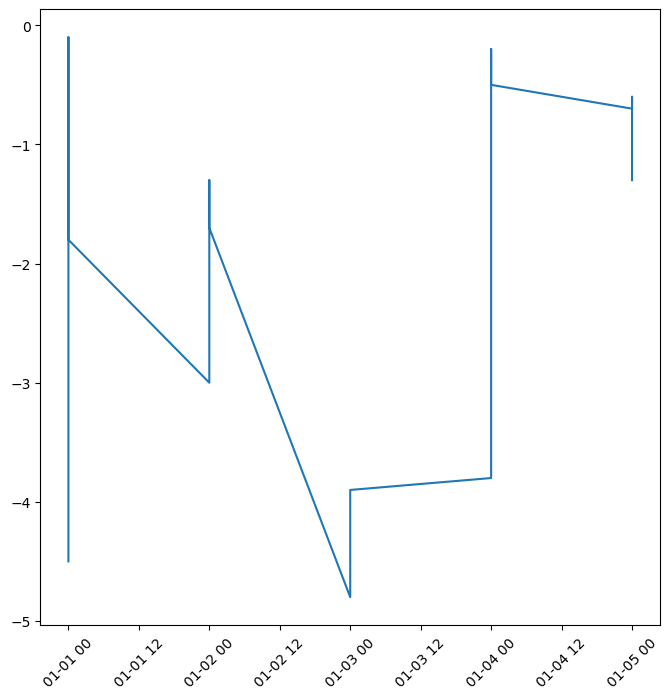

In [41]:
# DO NOT MODIFY OR COPY THIS CELL!! 
plot_value_series(missing_temp_df_list[missing_temp_idx], 'temp')
plot_value_series(handle_missing_temp_values(missing_temp_df_list[missing_temp_idx]), 'temp')

#### Handle missing air pressure values

Do the same for the air pressure values:

- Implement the function below to get rid of the missing values for air pressure (`airPressure`).
- Choose an appropriate strategy to fill in the misssing values.

In [42]:
def handle_missing_airPressure_values(df:pd.DataFrame) -> pd.DataFrame:
    """ 
    Handle missing air pressure values appropriately!

    Parameters
    --------
    df: dataframe containing the missing values
    
    Returns
    --------
    df_ret: dataframe with fixed values
    """
    df_ret = df.copy()

    df_ret = df_ret.fillna(method="ffill")

    return df_ret

Plot the fixed stretch of airPressure values from above:

In [43]:
missing_apr_idx = 0

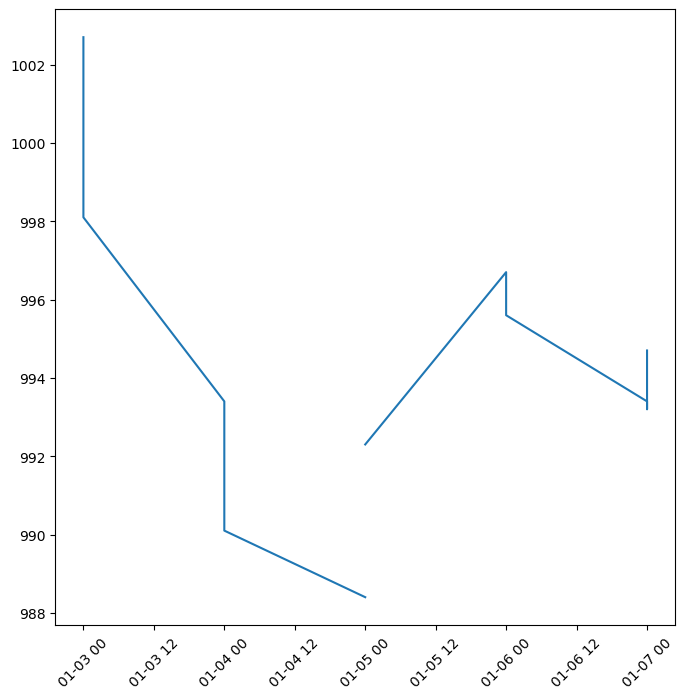

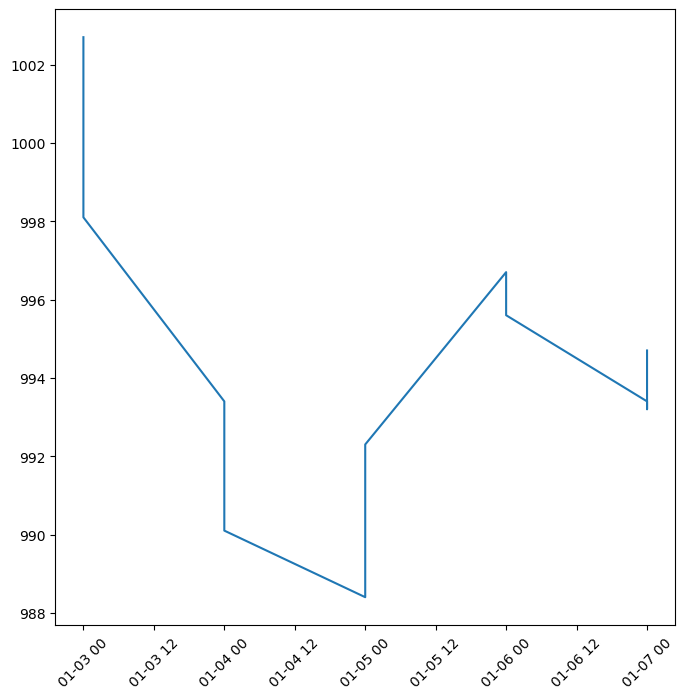

In [44]:
# DO NOT MODIFY OR COPY THIS CELL!! 
plot_value_series(missing_airPressure_df_list[missing_apr_idx], 'airPressure')
plot_value_series(handle_missing_airPressure_values(missing_airPressure_df_list[missing_apr_idx]), 'airPressure')

In [45]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
# the function to get the short dataframes around missing values should now return an empty list if we fix all temp values!
empty_temp_list = get_data_around_missing(handle_missing_temp_values(weather_data), 'temp')
empty_airPressure_list = get_data_around_missing(handle_missing_airPressure_values(weather_data), 'airPressure')
assert len(empty_temp_list) == 0
assert len(empty_airPressure_list) == 0

In [46]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

#### Discussion
Write down what strategy you chose for temperature and airPressure and motivate why you decided for the strategies:

I choosed to fill the missing values but propagating to the previous value. When it is from the same day the difference isnt that great. If i could take the mean value for the whole column isnt gonna be great, because the time diffrence is 2 4 days and the values could change fast.

### 2.2 Missing wind direction values

#### Data inspection
Check the assumption for missing wind direction values and handle the missing wind direction values in an appropriate way.

In [47]:
# write some code to check the assumtion for missing values of windDir
print("Missing values for windDir is",  weather_data.reset_index().windDir.isna().sum())

values = {}
for i in range(2009, 2022):
    value1 = weather_data.reset_index().groupby("year")["windDir"].value_counts().loc[i].index[0]
    value2 = weather_data.reset_index().groupby("year")["windDir"].value_counts().loc[i].index[1]

    vl1 = weather_data.reset_index().groupby("year")["windDir"].value_counts().loc[i].iloc[0]
    vl2 = weather_data.reset_index().groupby("year")["windDir"].value_counts().loc[i].iloc[1]

    values[i] = [{value1: vl1}, {value2: vl2}]
values
    

Missing values for windDir is 184


{2009: [{'W': 319}, {'NW': 224}],
 2010: [{'W': 307}, {'NW': 226}],
 2011: [{'W': 315}, {'SE': 213}],
 2012: [{'W': 313}, {'NW': 241}],
 2013: [{'W': 258}, {'NW': 249}],
 2014: [{'SE': 275}, {'W': 271}],
 2015: [{'W': 304}, {'NW': 202}],
 2016: [{'W': 311}, {'NW': 223}],
 2017: [{'W': 380}, {'NW': 221}],
 2018: [{'W': 230}, {'NW': 221}],
 2019: [{'W': 282}, {'NW': 246}],
 2020: [{'W': 284}, {'NW': 201}],
 2021: [{'W': 302}, {'NW': 257}]}

Explain what you did and what your findings are. Also propose a strategy to fix the missing values appropriately:

We can see that for each year we have the majotity of the wind direction is coming from west and second place we have Nord west. Also the missing values are just 184 from 14244 observations. So we I will chose just the majority of the NaN values to replace with W

#### Handle missing wind direction values
Implement a function that fixes the missing wind direction values.

In [48]:
def handle_missing_windDir_values(df:pd.DataFrame) -> pd.DataFrame:
    df_ret = df.copy()
    
    df_ret.windDir = df_ret.windDir.fillna(df_ret.windDir.mode().loc[0]).isna().sum()
    
    return df_ret

In [49]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
# Apply the windDir fix and check if any missing values remain
fix_wind_dir = handle_missing_windDir_values(weather_data)
assert fix_wind_dir[fix_wind_dir['windDir'].isnull()].empty

In [50]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

### 2.3 Combine all fixes to get clean data

In [51]:
def handle_missing_values_weather(data:pd.DataFrame) -> pd.DataFrame:
    """ 
    Parameters
    --------
    data: data frame containing missing values 
    
    Returns
    --------
    data: data frame not containing any missing values
    """
    data_clean = data.copy()
    for col in data_clean.columns:
        if (np.issubdtype(data_clean[col].dtype, np.number) and col != "date"):
            data_clean[col] = data_clean[col].fillna(method="ffill") 
        if (col != "date" and np.issubdtype(data[col].dtype, np.number) == False):
            data_clean[col] = data_clean[col].replace(np.nan, data_clean["windDir"].mode().loc[0])
    
    return data_clean

In [52]:
# DO NOT MODIFY OR COPY THIS CELL!!
weather_data_complete = handle_missing_values_weather(weather_data)

In [53]:
print(f"Before: \n---------\n{weather_data.isna().sum()}")
print(f"\nAfter: \n---------\n{weather_data_complete.isna().sum()}")

Before: 
---------
attributes
date             0
airPressure    181
hum              0
skyCover         0
temp           231
windBeauf        0
windDir        184
dtype: int64

After: 
---------
attributes
date           0
airPressure    0
hum            0
skyCover       0
temp           0
windBeauf      0
windDir        0
dtype: int64


In [54]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
# check if missing values are no longer present
assert not weather_data_complete.isna().any().any()
assert weather_data_complete.shape[0] == weather_data.shape[0]
assert weather_data_complete.shape[1] == weather_data.shape[1]

In [55]:
weather_data

attributes                      date  airPressure  hum  skyCover  temp  \
year month week day hours                                                
2009 1     1    1   7     2009-01-01        999.7   79        10  -4.5   
                    14    2009-01-01        998.8   71         5  -0.1   
                    19    2009-01-01       1000.7   72        10  -1.8   
                2   7     2009-01-02        999.6   67        10  -3.0   
                    14    2009-01-02        998.5   66         9  -1.3   
...                              ...          ...  ...       ...   ...   
2021 12    52   30  14    2021-12-30        993.3   88         8   9.5   
                    19    2021-12-30        995.1   97         9   7.2   
                31  7     2021-12-31        996.8   77         3  12.9   
                    14    2021-12-31        996.2   62         3  15.9   
                    19    2021-12-31        994.6   72         3  13.3   

attributes                 windBeauf windDir  
year month week day hours                     
2009 1     1    1   7              2       W  
                    14             2      NW  
                    19             2      NW  
                2   7              0     NaN  
                    14             2       W  
...                              ...     ...  
2021 12    52   30  14             1       E  
                    19             1      NE  
                31  7              4       W  
                    14             3      NW  
                    19             3       W  

[14244 rows x 7 columns]

## Task 3: Handling Outliers (10 Points)

Additionally to the missing values, the dataset also seems to have some strange values, that are probably outliers. 
When confronted with the data, the meterologist gave you a bit more information:


1. Sometimes the temperture readings seem to be off, without any good reason.

2. In the timespan from early October 2015 until mid March 2016, the wind sensor was defective: it might have displayed wrong values for winds from SE direction.

3. In the `daily_weather_data`, the precipitation column contains some non-numeric values.

4. The precipitation sensor usually produces wrong values when hail is involved.






### 3.1 Temperature outliers
First we want ot take a closer look at the temperature values. Check if we can identify some obvious outliers and come up with a strategy to handle/fix them.

In order to do so you will have to:
- Plot the temperature curve over time and a histogram of temperature values to identify possible outliers
- Plot a zoomed in version of individual outliers to get a better understanding what's happening
- Devise a strategy to get rid of outliers

#### Investigation
Implement the function below to create a plot of the temperature values (`temp`) over time. Additionally create a histogram with reasonable bins to identify the outliers:

In [56]:
def plot_temp_analysis(df: pd.DataFrame) -> None:
    """
    Create two plots:
    1) Temperature values over time for the whole dataframe
    2) A histogram for temperature values. 
       Choose appropriate bins enabling you to identify outliers!

    Parameters
    --------
    df: data frame containint the temperature values (temp) with potential outlier
    
    """

    fig, axs = plt.subplots(2)
    axs[0].plot(df.date, df.temp)
    axs[1].hist(df.temp)
    fig.show()


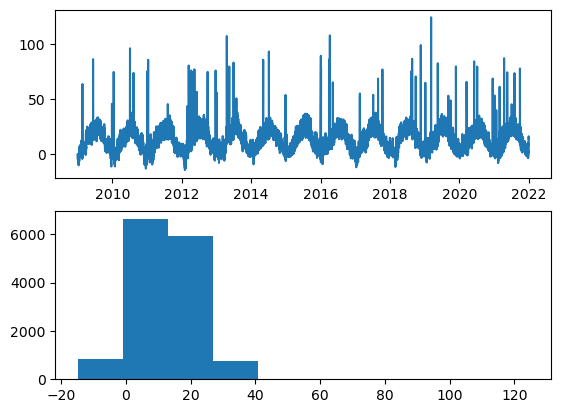

In [57]:
# DO NOT MODIFY OR COPY THIS CELL!!
plot_temp_analysis(weather_data_complete)

In [58]:
# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

In the next cell, select a random outlier (e.g. the first) and plot the temperature curve around the outlier.

<AxesSubplot: xlabel='date'>

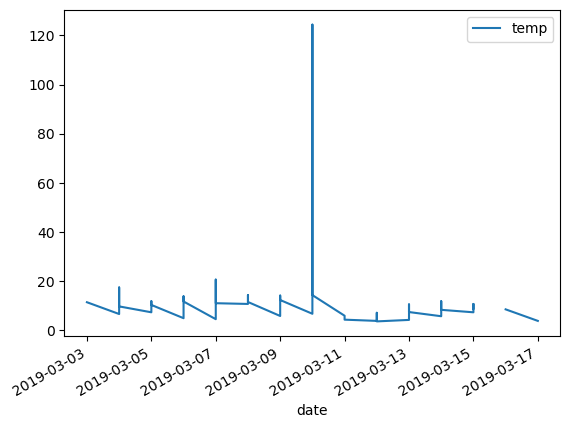

In [59]:
picket_row=weather_data.temp.max()

show_data = weather_data.reset_index().sort_index()
indexOutlier=show_data.index[show_data['temp'] == picket_row] 

list_rows=[]
for a in range(-20,21):
    list_rows.append(show_data.iloc[indexOutlier+a])
x=pd.concat(list_rows)
x.plot(x="date", y="temp")

In [60]:
# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

Express your findings and define a strategy to get rid of the outliers:

YOUR ANSWER HERE

#### Remove temperature outliers
Implement the below function using the strategy you defined above to get rid of the temperature outliers

In [61]:
def handle_temp_outliers(noisy_data) -> pd.DataFrame:
    """
    Parameters
    --------
    noisy_data: data frame that contains temperature outliers ('temp' column)

    Returns
    --------
    cleaned_data: data frame with temperature outliers removed/handled
    """
    import random
    temps = noisy_data[noisy_data.temp < 45].temp.values
    noisy_data_cp = noisy_data.copy() 
    noisy_data_cp.temp = noisy_data_cp['temp'].where(noisy_data_cp['temp'] < 45, random.choice(temps))
    
    cleaned_data = noisy_data_cp.copy()
    
    return cleaned_data

count    14244.000000
mean        12.306602
std          9.041762
min        -14.900000
25%          5.100000
50%         12.100000
75%         19.200000
max         43.590868
Name: temp, dtype: float64


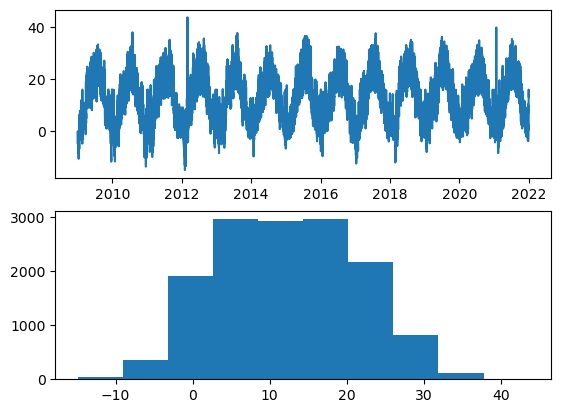

In [62]:
# DO NOT MODIFY OR COPY THIS CELL!!
weather_data_cleaned = handle_temp_outliers(weather_data_complete)
plot_temp_analysis(weather_data_cleaned)
print(weather_data_cleaned['temp'].describe())

In [63]:
# test, DO NOT MODIFY OR COPY THIS CELL!!

# check if new missing values were introduced
assert not weather_data_cleaned.isna().any().any()
# check if outliers were simply dropped
assert weather_data_cleaned.shape == weather_data_complete.shape

In [64]:
# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

In [65]:
# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

### 3.2 Wind speed outliers

The second outlier problem was, that in the timespan from early October 2015 until mid March 2016, the wind sensor was defective: it might have displayed wrong values for winds from SE direction.

Double check if this is true, and if it is, fix the values appropriately.

#### Data inspection

Implement the function below to visualize the problematic wind sensor data.
Complete the function below to check the assumtions for wrong values of windBeauf.
- Plot the wind speed data over the questionable time duration (early October 2015 until mid March 2016)
- Plot a histogram of the windspeed values to identify outliers
- Check if the assumtion regarding the wind direction is true (errors only from SE direction)

Bonus:
- Find out when exactly the sensor started to produce wrong values and when the sensor was fixed!

In [66]:
def analyze_wind_range(df:pd.DataFrame) -> typing.Tuple[int, typing.List[str]]:
    """
    Plot analysis plots for the wind data. Print outputs about relevant data 
    and return the relevant values as indicated.

    Parameters
    --------
    noisy_data: data frame that contains outliers
    
    Returns
    --------
    wind_dir_outliers: list of wind direction string code, for which outliers where found
    num_outliers: number of found outliers

    """

    num_outliers = 0  # return a value that reflects how many outliers you identified
    wind_dir_outliers = [] # a list of the string codes for wind directions where you identified outliers from


    selected_range = df[(df.date >= "2015-10-01") & (df.date <= "2016-03-31")]
    selected_range = selected_range.sort_values("date")
    
    fig, axs = plt.subplots(2)
    axs[0].plot(selected_range.date, selected_range.windBeauf)
    axs[1].hist(selected_range.windBeauf)
    print("We can see more of the values are from th SE direction ")
    print(selected_range[selected_range.windBeauf >= 10].windDir.value_counts())
    
    wind_dir_outliers = selected_range[selected_range.windBeauf >= 10].windDir.values
    num_outliers = len(wind_dir_outliers)
    return wind_dir_outliers, num_outliers


We can see more of the values are from th SE direction 
SE    90
Name: windDir, dtype: int64


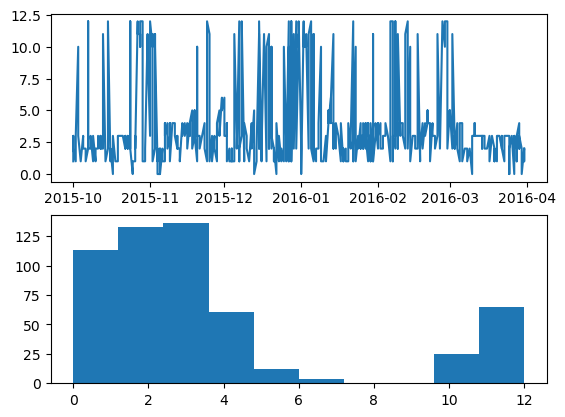

In [67]:
# DO NOT MODIFY OR COPY THIS CELL!!
wind_dir_outliers, num_outliers = analyze_wind_range(weather_data_complete)

In [68]:
assert 0 < num_outliers < 500, "there should be more than zero but less than 500 outliers!"
assert len(wind_dir_outliers) > 0, "there should be at least one wind direction!"
assert isinstance(wind_dir_outliers[0], str), "the wind direction codes are strings with two characters!"
assert len(wind_dir_outliers[0]) == 2, "the wind direction codes are strings with two characters!"

# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

#### Fix wind sensor outliers
Fix the values appropriately. Implement a function that compensates for the problem you found.

In [69]:
weather_data_complete.loc[(weather_data_complete['windBeauf'] >= 10) & (weather_data_complete['windDir'] == "SE") & (weather_data_complete['windDir'] == "W") & (weather_data_complete.date >= "2015-10-01") & (weather_data_complete.date <= "2016-03-31"), ["windBeauf"]] = 2.7


In [70]:
def fix_windBeauf_values(df:pd.DataFrame) -> pd.DataFrame:
    """
    Parameters
    --------
    df: data frame that contains potential faulty wind values

    Returns
    -------
    df_ret: data frame with fixed wind values
    """

    df_ret = df.copy()
    
    df_ret.loc[(df_ret['windBeauf'] >= 10) & (df_ret['windDir'] == "SE") & (df_ret.date >= "2015-10-01") & (df_ret.date <= "2016-03-31"), ["windBeauf"]] = 2.7


    return df_ret

We can see more of the values are from th SE direction 
Series([], Name: windDir, dtype: int64)


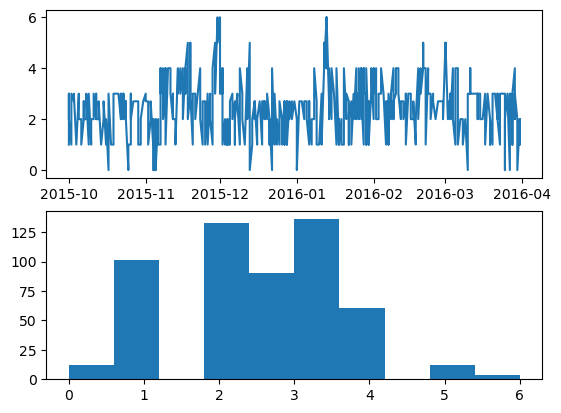

In [71]:
# test, DO NOT MODIFY OR COPY THIS CELL!!
weather_data_fix_wind = fix_windBeauf_values(weather_data_complete)
wind_dir_outliers_fixed, num_outliers_fixed = analyze_wind_range(weather_data_fix_wind)

In [72]:
# test, DO NOT MODIFY OR COPY THIS CELL!!
assert num_outliers_fixed == 0, "now no outliers should be found"
assert len(wind_dir_outliers_fixed) == 0, "now no outliers should be found, so no directions!"
assert weather_data_fix_wind.shape == weather_data_complete.shape

# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

### 3.3 Daily weather data: precipitation

When loading the data, we separated the precipitation data into the `daily_weather_data` dataframe.
This dataframe also has an issues:

- The `precip` column contains some non-numeric values 

#### Data inspection
Check the occurance of the non-numeric values in the precipitation data. You can check the file `data/weather/description.txt`, which might have additional clues what is going on.

Implement the function below and return a list of the non-numeric values that occur in the `precip` column of `daily_weather_data`. Make sure to only return every unique value once! 

In [73]:
def get_non_numeric_precip_values(df:pd.DataFrame) -> typing.Set[str]:
    """
    Parameters
    --------
    df: data frame that contains non-numeric values in precip column

    Returns
    -------
    non_numeric_values: list of unique non-numeric values. 
    Do not return duplicate values in the list!
    """
    non_numeric_values = set()
    for v in df.precip.unique():
        try:
            isinstance(float(v), float)
        except:
            non_numeric_values.add(v)

    return non_numeric_values

In [74]:
# DO NOT MODIFY OR COPY THIS CELL!!
non_numeric_values = get_non_numeric_precip_values(daily_weather_data)
print(f"\nnon-numeric values values: {non_numeric_values}")


non-numeric values values: {'traces'}


In [75]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
assert isinstance(non_numeric_values, set) , "make sure to return a set, so no duplicate values can be returned!!"
assert len(non_numeric_values) > 0, "there should be some non-numeric values in daily_weather_data!"
assert isinstance(list(non_numeric_values)[0], str), "only return the non-numeric values as strings!"

#### Fix non-numeric values
Replace non-numeric values with some appropriate numerical values and convert the column to a more suitable data type.
To get an idea, what appropriate values might be, check the file `data/weather/description.txt` and the other numeric values in the `precip` column.

In [76]:
def fix_precip_values(df:pd.DataFrame) -> pd.DataFrame:
    """
    Parameters
    --------
    df: data frame that contains non-numeric values in precip column

    Returns
    -------
    ret_df: data frame with fixed precip values
    """
    ret_df = df.copy()

    num_vals = []
    for v in ret_df.precip.unique():
        try:
            isinstance(float(v), float)
            num_vals.append(float(v))
        except:
            continue
    
    mean = np.round(sum(num_vals) / len(num_vals), 1)
    ret_df.precip = ret_df.precip.replace("traces", mean)
    ret_df.precip = ret_df.precip.astype('float')

    return ret_df

In [77]:
# DO NOT MODIFY OR COPY THIS CELL!!
daily_weather_data_fixed_precip = fix_precip_values(daily_weather_data)

In [78]:
# test, DO NOT MODIFY OR COPY THIS CELL!!
assert pd.api.types.is_float_dtype(daily_weather_data_fixed_precip['precip'].dtype), "precip should now be a float column!!"
assert daily_weather_data_fixed_precip.shape == daily_weather_data.shape, "do not remove or add rows!"

### Combining the fixes

In [79]:
# DO NOT MODIFY OR COPY THIS CELL!!
def fix_values_daily(data):
    """ 
    Parameters
    --------
    data: data frame containing missing values 
    
    Returns
    --------
    complete_data: data frame not containing any missing values
    """
    complete_data = data.copy()
    complete_data = fix_precip_values(complete_data)
    
    return complete_data

   
def handle_outliers(data):
    """ 
    Parameters
    --------
    data: data frame containing outlier values 
    
    Returns
    --------
    complete_data: data frame not containing any outlier values
    """
    complete_data = data.copy()
    complete_data = handle_temp_outliers(complete_data)
    complete_data = fix_windBeauf_values(complete_data)
    
    return complete_data

In [80]:
# DO NOT MODIFY OR COPY THIS CELL!!
daily_weather_data_finished = fix_values_daily(daily_weather_data)
weather_data_finished = handle_outliers(weather_data_complete)

## Task 4: Aggregate values (5 Points)

Aggregate the observations on a weekly basis. Return a data frame with a hierarchical index (levels `year` and `week`) and the following weekly aggregations as columns:

- `temp_weeklyMin`: minimum of `temp`
- `temp_weeklyMax`: max of `temp`
- `temp_weeklyMean`: mean of `temp`
- `temp_weeklyMedian`: median of `temp`

- `hum_weeklyMin`: min of `hum`
- `hum_weeklyMax`: max of `hum`
- `hum_weeklyMean`: mean of `hum`

- `wind_weeklyMean`: mean of `windBeauf`
- `wind_weeklyMax`: max of `windBeauf`
- `wind_weeklyMin`: min of `windBeauf`

Additionally merge the precipitation values from the `daily_weather_data` dataframe also into the newly created dataframe and aggregate them into the folling columns:
- `precip_weeklyMin`: min of `precip`
- `precip_weeklyMax`: max of `precip`
- `precip_weeklyMean`: mean of `precip`


**Note:** Attentive data scientists might have noticed a problem with isocalendars when aggregating on `Year` and `Week`. You can ignore this for the purpose of this lecture. In real-world settings you might consider addressing this issue, depending on your task and data

### daily_weather_data_finished

In [110]:
def aggregate_weekly(hourly_data, data_daily):
    """ 
    Parameters
    --------
    hourly_data: hourly weather data frame, containing temp, hum, and wind values.
    data_daily: daily weather data frame with precip values
    
    Returns
    --------
    weekly_stats: data frame that contains statistics aggregated on a weekly basis
    """
    weekly_weather_data = pd.DataFrame()

    mergerd = pd.merge(weather_data_finished, daily_weather_data_finished, left_index=True, right_index=True)

    mergerd = mergerd.rename(columns={"date_x": "date"})

    min_cols = mergerd.reset_index().groupby(["year", "week"]).min()[["temp", "hum", "windBeauf", "precip"]].rename(columns={"temp": "temp_weeklyMin", "hum": "hum_weeklyMin", "windBeauf": "wind_weeklyMin", "precip": "precip_weeklyMin"})
    max_cols = mergerd.reset_index().groupby(["year", "week"]).max()[["temp", "hum", "windBeauf", "precip"]].rename(columns={"temp": "temp_weeklyMax", "hum": "hum_weeklyMax", "windBeauf": "wind_weeklyMax", "precip": "precip_weeklyMax"})
    mean_cols = mergerd.reset_index().groupby(["year", "week"]).mean()[["temp", "hum", "windBeauf", "precip"]].rename(columns={"temp": "temp_weeklyMean", "hum": "hum_weeklyMean", "windBeauf": "wind_weeklyMean", "precip": "precip_weeklyMean"})
    median_cols = mergerd.reset_index().groupby(["year", "week"]).mean()[["temp"]].rename(columns={"temp": "temp_weeklyMedian"})
    
    weekly_weather_data = pd.concat([min_cols, max_cols, mean_cols, median_cols], axis=1)
    return weekly_weather_data

In [111]:
# DO NOT MODIFY OR COPY THIS CELL!!
weekly_weather_data = aggregate_weekly(weather_data_finished, daily_weather_data_finished)
display(weekly_weather_data)

/tmp/ipykernel_211/3471051484.py:18: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  min_cols = mergerd.reset_index().groupby(["year", "week"]).min()[["temp", "hum", "windBeauf", "precip"]].rename(columns={"temp": "temp_weeklyMin", "hum": "hum_weeklyMin", "windBeauf": "wind_weeklyMin", "precip": "precip_weeklyMin"})
/tmp/ipykernel_211/3471051484.py:19: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  max_cols = mergerd.reset_index().groupby(["year", "week"]).max()[["temp", "hum", "windBeauf", "precip"]].rename(columns={"temp": "temp_weeklyMax", "hum": "hum_weeklyMax", "windBeauf": "wind_weeklyMax", "precip": "precip_weeklyMax"})
/tmp/ipykernel_211/3471051484.py:20: F

temp_weeklyMin  hum_weeklyMin  wind_weeklyMin  precip_weeklyMin  \
year week                                                                    
2009 1               -4.8             62             0.0               0.0   
     2              -10.6             61             0.0               0.0   
     3               -7.0             69             1.0               0.0   
     4                0.3             40             1.0               0.0   
     5               -2.4             66             1.0               0.0   
...                   ...            ...             ...               ...   
2021 49              -2.2             66             1.0               0.0   
     50               2.5             65             1.0               0.0   
     51              -3.8             50             1.0               0.0   
     52              -1.4             62             1.0               0.0   
     53              -2.5             84             1.0               0.1   

           temp_weeklyMax  hum_weeklyMax  wind_weeklyMax  precip_weeklyMax  \
year week                                                                    
2009 1               -0.1             83             4.0              15.3   
     2               -0.6             91             4.0              15.3   
     3                3.1             95             4.0              15.3   
     4                7.8             94             4.0              15.3   
     5                4.8             94             4.0              15.3   
...                   ...            ...             ...               ...   
2021 49               4.6             97             4.0              15.3   
     50               8.3             91             4.0              15.3   
     51              10.3             98             4.0              15.3   
     52              15.9             98             4.0              15.3   
     53               5.4             99             3.0              15.3   

           temp_weeklyMean  hum_weeklyMean  wind_weeklyMean  \
year week                                                     
2009 1           -2.533333       70.500000         2.333333   
     2           -4.780952       78.523810         2.095238   
     3           -3.119048       86.428571         2.095238   
     4            3.471429       76.666667         2.238095   
     5            0.414286       84.238095         2.714286   
...                    ...             ...              ...   
2021 49           1.580952       82.809524         2.333333   
     50           5.738095       78.000000         3.142857   
     51           1.095238       76.619048         2.380952   
     52           5.406667       84.466667         2.200000   
     53           1.900000       91.888889         1.666667   

           precip_weeklyMean  temp_weeklyMedian  
year week                                        
2009 1              7.650000          -2.533333  
     2             10.928571          -4.780952  
     3              2.871429          -3.119048  
     4              6.857143           3.471429  
     5              6.300000           0.414286  
...                      ...                ...  
2021 49             4.257143           1.580952  
     50             2.514286           5.738095  
     51             3.128571           1.095238  
     52             5.080000           5.406667  
     53             5.366667           1.900000  

[682 rows x 13 columns]

In [112]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
assert len(weekly_weather_data.columns) >= 13, "according to the instructions, the dataframe should have >= 13 columns"
assert len(weekly_weather_data.index.levels) == 2, "according to the instructions, the dataframe should have a multi-index with 2 levels"

In [113]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

## Task 5: Merge influenza and weather datasets (5 Points)

Merge the `data_weather_weekly` and `data_influenza` datasets.
Both dataframes should now be on a weekly index. 
Beware that both datasets contain rows that do not appear in the other dataset.

In [114]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
# Neither of the tables contain missing data

print(f"influenza data, missing data (should be 0): \n{data_influenza.isna().sum()}")
print(f"weather data, missing data (should be 0): \n{weekly_weather_data.isna().sum()}")

assert not data_influenza.isna().any().any(), "we should have eliminated all missing values!!"
assert not weekly_weather_data.isna().any().any(), "we should have eliminated all missing values!!"

influenza data, missing data (should be 0): 
weekly_infections    0
dtype: int64
weather data, missing data (should be 0): 
temp_weeklyMin       0
hum_weeklyMin        0
wind_weeklyMin       0
precip_weeklyMin     0
temp_weeklyMax       0
hum_weeklyMax        0
wind_weeklyMax       0
precip_weeklyMax     0
temp_weeklyMean      0
hum_weeklyMean       0
wind_weeklyMean      0
precip_weeklyMean    0
temp_weeklyMedian    0
dtype: int64


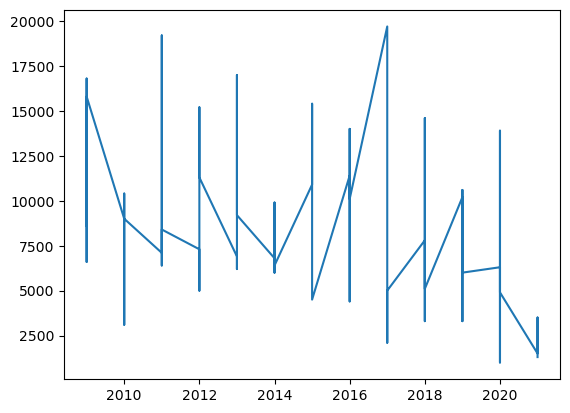

In [128]:
# use this cell for experimentation / analysis for merging data
plt.plot(data_influenza.reset_index().sort_values("year").year, data_influenza.reset_index().sort_values("year").weekly_infections)

In [130]:
pd.merge(weekly_weather_data, data_influenza, left_index=True, right_index=True)

temp_weeklyMin       0
hum_weeklyMin        0
wind_weeklyMin       0
precip_weeklyMin     0
temp_weeklyMax       0
hum_weeklyMax        0
wind_weeklyMax       0
precip_weeklyMax     0
temp_weeklyMean      0
hum_weeklyMean       0
wind_weeklyMean      0
precip_weeklyMean    0
temp_weeklyMedian    0
weekly_infections    0
dtype: int64

In [ ]:
def merge_data(weather_df, influenza_df):
    """ 
    Parameters
    --------
    weather_df: weekly weather data frame
    influenza_df: influenza data frame
    
    Returns
    --------
    merged_data: merged data frame that contains both weekly weather observations and prevalence of influence infections
    """
    

    return merged_data

In [ ]:
# DO NOT MODIFY OR COPY THIS CELL!!
data_merged = merge_data(weekly_weather_data, data_influenza)
data_merged.head()

In [ ]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
print(data_merged.shape)
assert data_merged.shape[0] > 300, "there should be more than 300 rows in the merged dataset"
assert data_merged.shape[1] >= 14, "1 column for infections, 13 feature columns from weather data"


## Store processed data for Tasks 6-8

Here we export the prepared dataset for usage in the notebook B.
If you encounter problems with the first five tasks, you can load a pickled `DataFrame` containing already merged and preprocessed weather and influenza datasets. You can use this data to complete tasks 6-8 in notebook B. 

In [ ]:
with open(os.path.join(os.path.expanduser( '~' ), "data_processed.pickle"),"wb") as fp:
    pickle.dump(data_merged, fp)  

## Congratulations, you are done!

Reminder:
Before you turn this assignment in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).